In [1]:
import numpy as np
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
data='bird_dataset_small'
batch_size=1 #64
epochs=10
lr=0.005
momentum=0.5
seed=1
log_interval=5
experiment='experiment/first'
num_workers=4
use_cuda = torch.cuda.is_available()

In [43]:
# Data initialization and loading
import PIL.Image as Image
from data import data_to_tensor

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + '/train_images',
                         transform=data_to_tensor),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + '/val_images',
                         transform=data_to_tensor),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

# load all the images from path : data + 'test_images/mistery_category'
# and store them in a list
test_images = []
for file in os.listdir(data + '/test_images/mistery_category'):
    if file.endswith(".jpg"):
        img = Image.open(data + '/test_images/mistery_category/' + file)
        img = img.convert('RGB')
        img = np.array(img)
        test_images.append(img)
# create a loader for the test images using test_images list

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images
        self.transform = data_to_tensor

    def __getitem__(self, index):
        image = np.array(self.images[index])
        image = self.transform(image)
        return image, None

    def __len__(self):
        return len(self.images)

test_set = test_dataset(test_images)


## SIFT exploration

In [14]:
# create a feature extractor from cv2
sift = cv2.xfeatures2d.SIFT_create()
# draw a sample from the dataloader
sample = next(iter(train_loader))

AttributeError: module 'cv2' has no attribute 'xfeatures2d'

In [15]:

# get the image and the label
image, label = sample

# convert the image to numpy
image = image.numpy()
# get the first image
print(image.max())

image = image[1].transpose(1,2,0)*255

# convert the image to 8-bit
image = image.astype(np.uint8)
 # Converting image to grayscale
plt.imshow(image)
plt.show()

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
gray = np.uint8(gray)
 
# Applying SIFT detector
kp = sift.detect(gray, None)

# compute the descriptors
kp, des = sift.compute(gray, kp)
print(des.shape)
# Marking the keypoint on the image using circles
img = cv2.drawKeypoints(gray ,
                      kp ,
                      gray,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
plt.imshow(img)
plt.show()

NameError: name 'sample' is not defined

In [28]:
from tqdm.notebook import tqdm
# create a set of descriptors for each classes
descriptors = {}
for sample in tqdm(train_loader):
    image, label = sample
    image = image.numpy()
    for i in range(image.shape[0]):
        img = image[i].transpose(1,2,0)*255
        img = img.astype(np.uint8)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray = np.uint8(gray)
        kp = sift.detect(gray, None)
        kp, des = sift.compute(gray, kp)
        # des numpy array of shape (N, 128) to list
        des = des.tolist()

        if label[i].item() not in descriptors:
            descriptors[label[i].item()] = []

        descriptors[label[i].item()].append(des)
        # break
    # break

  0%|          | 0/17 [00:00<?, ?it/s]

In [74]:
all_descriptors = []
for key in descriptors:
    for des in descriptors[key]:
        all_descriptors.extend(des)
# create a numpy array of shape (N, 128)
print(len(all_descriptors), len(all_descriptors[0]))
all_descriptors = np.array(all_descriptors)

560649 128


In [114]:
# create a kmeans object
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=300, random_state=0).fit(all_descriptors)

In [115]:
# save the kmeans object
import pickle
with open('experiment/kmeans/kmeans_300.pkl', 'wb') as f:
    pickle.dump(kmeans, f)


In [148]:
# open the kmeans object
import pickle
kmeans = KMeans(n_clusters=300, random_state=0)
with open('experiment/kmeans/kmeans_100.pkl', 'rb') as f:
    kmeans = pickle.load(f)

  0%|          | 0/2 [00:00<?, ?it/s]

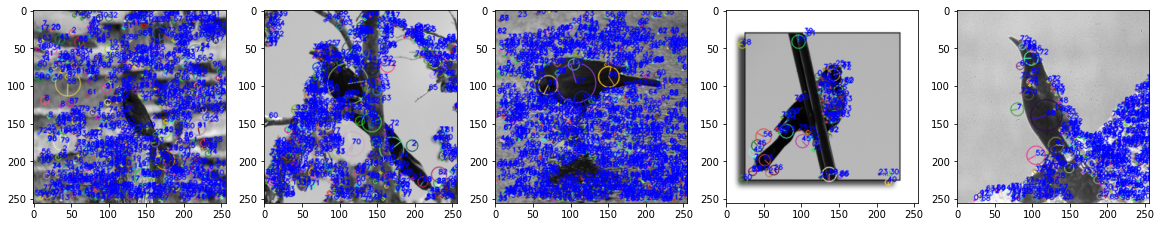

In [149]:
# compute the descriptors for the validation set and their label associated
# plot the results 
descriptors = {}
labels = {}
plt.figure(figsize=(20, 20))
for sample in tqdm(val_loader):
    image, label = sample
    image = image.numpy()
    for i in range(image.shape[0]):
        img = image[i].transpose(1,2,0)*255
        img = img.astype(np.uint8)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray = np.uint8(gray)
        kp = sift.detect(gray, None)
        kp, des = sift.compute(gray, kp)
        # des numpy array of shape (N, 128) to list
        des = des.tolist()

        if label[i].item() not in descriptors:
            descriptors[label[i].item()] = []

        if label[i].item() not in labels:
            labels[label[i].item()] = []

        kmeans_labels = kmeans.predict(des)

        # plot the the image the keypoint and the label
        img = cv2.drawKeypoints(gray ,
                        kp ,
                        gray,
                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        # add the label
        for j in range(len(kp)):
            cv2.putText(img, str(kmeans_labels[j]), (int(kp[j].pt[0]), int(kp[j].pt[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
            # cv2.putText(img, str(kmeans_labels[j]), (int(kp[j].pt[0]), int(kp[j].pt[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        
        if (i == 4):
            plt.show() 
            break

    break

In [150]:
# compute the histogram for each image
hists_train = {}
for sample in tqdm(train_loader):
    image, label = sample
    image = image.numpy()
    for i in range(image.shape[0]):
        img = image[i].transpose(1,2,0)*255
        img = img.astype(np.uint8)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray = np.uint8(gray)
        kp = sift.detect(gray, None)
        kp, des = sift.compute(gray, kp)
        # des numpy array of shape (N, 128) to list
        des = des.tolist()

        if label[i].item() not in descriptors:
            descriptors[label[i].item()] = []

        if label[i].item() not in labels:
            labels[label[i].item()] = []

        kmeans_labels = kmeans.predict(des)

        hist = np.zeros(300)
        for j in range(len(kmeans_labels)):
            hist[kmeans_labels[j]] += 1

        if label[i].item() not in hists_train:
            hists_train[label[i].item()] = []

        hists_train[label[i].item()].append(hist.tolist())

        # break

hists_val = {}
for sample in tqdm(val_loader):
    image, label = sample
    image = image.numpy()
    for i in range(image.shape[0]):
        img = image[i].transpose(1,2,0)*255
        img = img.astype(np.uint8)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray = np.uint8(gray)
        kp = sift.detect(gray, None)
        kp, des = sift.compute(gray, kp)
        # des numpy array of shape (N, 128) to list
        des = des.tolist()

        if label[i].item() not in descriptors:
            descriptors[label[i].item()] = []

        if label[i].item() not in labels:
            labels[label[i].item()] = []

        kmeans_labels = kmeans.predict(des)

        hist = np.zeros(300)
        for j in range(len(kmeans_labels)):
            hist[kmeans_labels[j]] += 1

        if label[i].item() not in hists_val:
            hists_val[label[i].item()] = []

        hists_val[label[i].item()].append(hist.tolist())

        # break
    # break


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

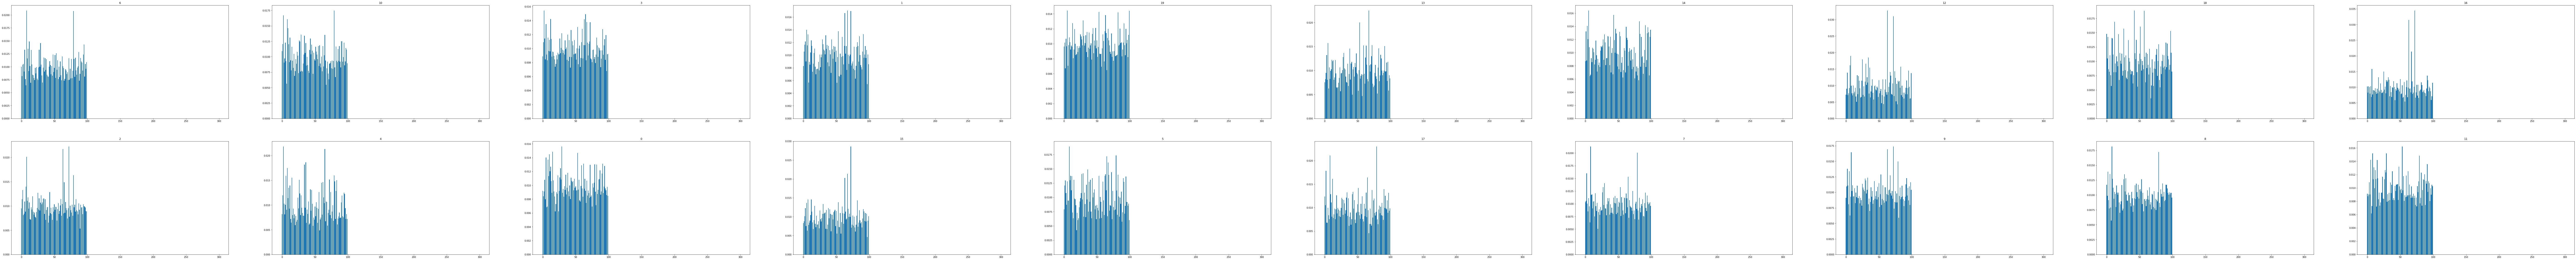

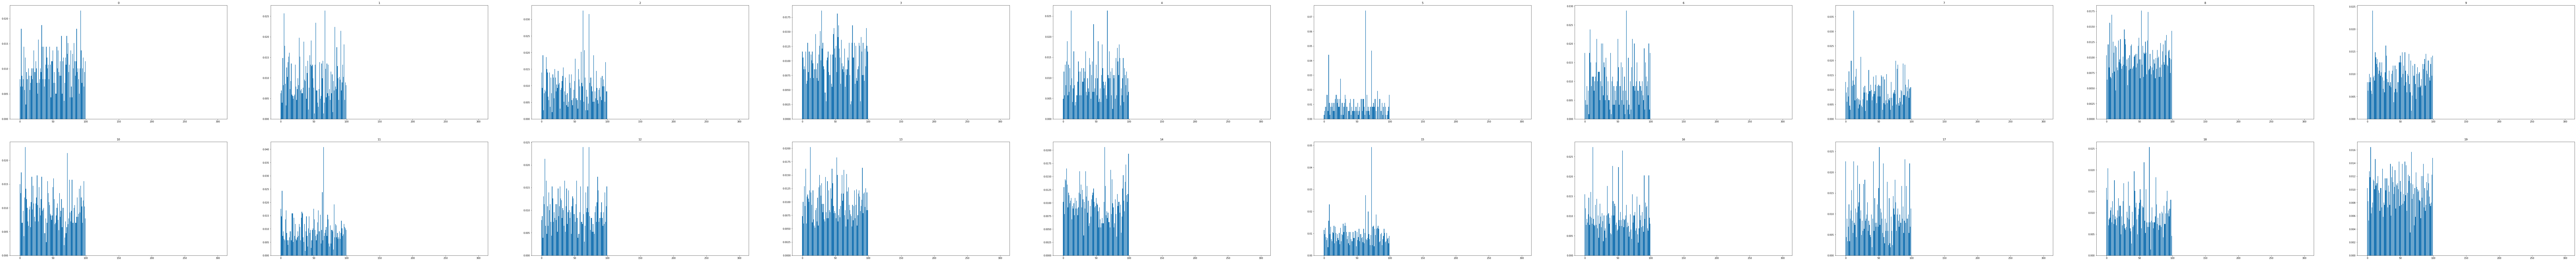

In [151]:
mean_hists = {}
for key in hists_train:
    mean_hists[key] = np.mean(hists_train[key], axis=0)
    # normalize the histogram
    mean_hists[key] = mean_hists[key] / np.sum(mean_hists[key])

# plot the histogram for each class
plt.figure(figsize=(200, 20))
for i, key in enumerate(mean_hists):
    plt.subplot(2, 10, i+1)
    plt.bar(range(300), mean_hists[key])
    plt.title(key)

plt.show()

# compute the same for the validation set
mean_hists_val = {}
for key in hists_val:
    mean_hists_val[key] = np.mean(hists_val[key], axis=0)
    # normalize the histogram
    mean_hists_val[key] = mean_hists_val[key] / np.sum(mean_hists_val[key])

# plot the histogram for each class
plt.figure(figsize=(200, 20))
for i, key in enumerate(mean_hists_val):
    plt.subplot(2, 10, i+1)
    plt.bar(range(300), mean_hists_val[key])
    plt.title(key)
plt.show()

In [152]:


class customDataset:
    def __init__(self, hists) -> None:
        self.hists = hists
        self.n_keys = len(hists)
        self.keys = list(hists.keys())

    def __len__(self):
        return np.sum([len(self.hists[key]) for key in self.hists])

    def __getitem__(self, idx):
        i = idx % self.n_keys
        j = idx // self.n_keys
        key = self.keys[i]
        hist = self.hists[key][j]
        return np.array(hist), key

dataset_train = customDataset(hists_train)
dataset_val = customDataset(hists_val)

X_train = []
y_train = []
for sample in dataset_train:
    X_train.append(sample[0])
    y_train.append(sample[1])

X_val = []
y_val = []
for sample in dataset_val:
    X_val.append(sample[0])
    y_val.append(sample[1])


In [153]:
# import tf-idf 
from sklearn.feature_extraction.text import TfidfVectorizer

# normalize X_train and X_val
X_train = np.array(X_train)
X_val = np.array(X_val)

# compute a TF-IDF on X_train and X_val
# compute the idf
idf_train = np.log(X_train.shape[0] / (1 + np.sum(X_train > 0, axis=0)))
tf_train = X_train / np.sum(X_train, axis=1, keepdims=True)
tf_idf_train = tf_train * idf_train

idf_val = np.log(X_val.shape[0] / (1 + np.sum(X_val > 0, axis=0)))
tf_val = X_val / np.sum(X_val, axis=1, keepdims=True)
tf_idf_val = tf_val * idf_val

X_train = tf_idf_train
X_val = tf_idf_val

--------------------
Accuracy train:  1.0


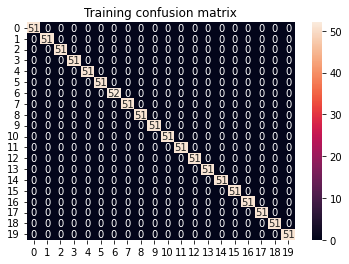

Accuracy val:  0.075


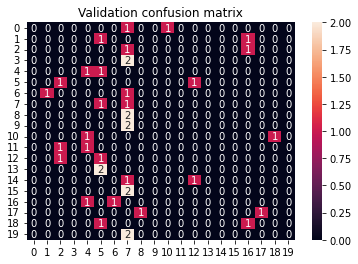

--------------------
--------------------
Accuracy train:  0.4515181194906954


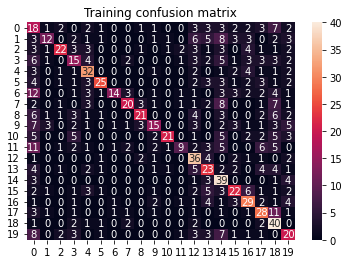

Accuracy val:  0.075


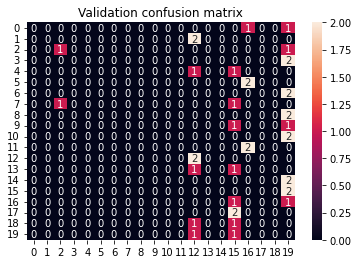

--------------------
--------------------
Accuracy train:  0.050930460333006855


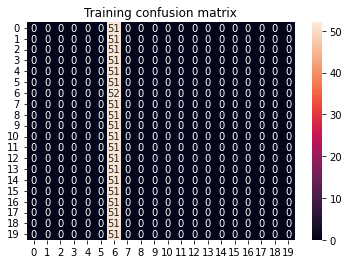

Accuracy val:  0.05


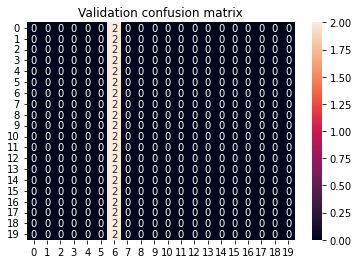

--------------------


In [154]:
# create classifiers and train it
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix
from seaborn import heatmap

def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    print("-"*20)
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    print("Accuracy train: ", accuracy_score(y_train, predictions))


    # confusion matrix
    cm = confusion_matrix(y_train, predictions)
    # use seaborn to plot the confusion matrix
    heatmap(cm, annot=True, fmt="d")
    plt.title("Training confusion matrix")
    plt.show()


    # plot the metrics for the validation set
    predictions = model.predict(X_val)
    print("Accuracy val: ", accuracy_score(y_val, predictions))

    # confusion matrix
    cm = confusion_matrix(y_val, predictions)
    # use seaborn to plot the confusion matrix
    heatmap(cm, annot=True, fmt="d")
    plt.title("Validation confusion matrix")
    plt.show()
    print("-"*20)





train_and_evaluate(RandomForestClassifier(), X_train, y_train, X_val, y_val)
train_and_evaluate(SVC(), X_train, y_train, X_val, y_val)
train_and_evaluate(LogisticRegression(), X_train, y_train, X_val, y_val)

## Exploration of the shape

In [49]:
from tqdm.notebook import tqdm

def plot_distribution_of_shape(dataloader):
    shapes = []
    for i, (img, _) in enumerate(tqdm(dataloader)):
        img = img.squeeze()
        shapes.extend(img.shape[1:])
        
    shapes = np.array(shapes)
    
    return shapes

In [50]:
# compute the distribution for all the images
shapes_train = plot_distribution_of_shape(train_loader)
shapes_val = plot_distribution_of_shape(val_loader)
shapes_test = plot_distribution_of_shape(test_set)

  0%|          | 0/532 [00:00<?, ?it/s]

In [83]:
print("The median of the distribution is: ", np.median(shapes_train))
print("The median of the distribution is: ", np.median(shapes_val))
print("The median of the distribution is: ", np.median(shapes_test))


The median of the distribution is:  221.0
The median of the distribution is:  221.5
The median of the distribution is:  185.5


The shapes are arround :  232.4630314232902  +-  88.55257334010277
The shapes are arround :  235.27184466019418  +-  87.00348103456096
The shapes are arround :  204.6015037593985  +-  115.8221552720983


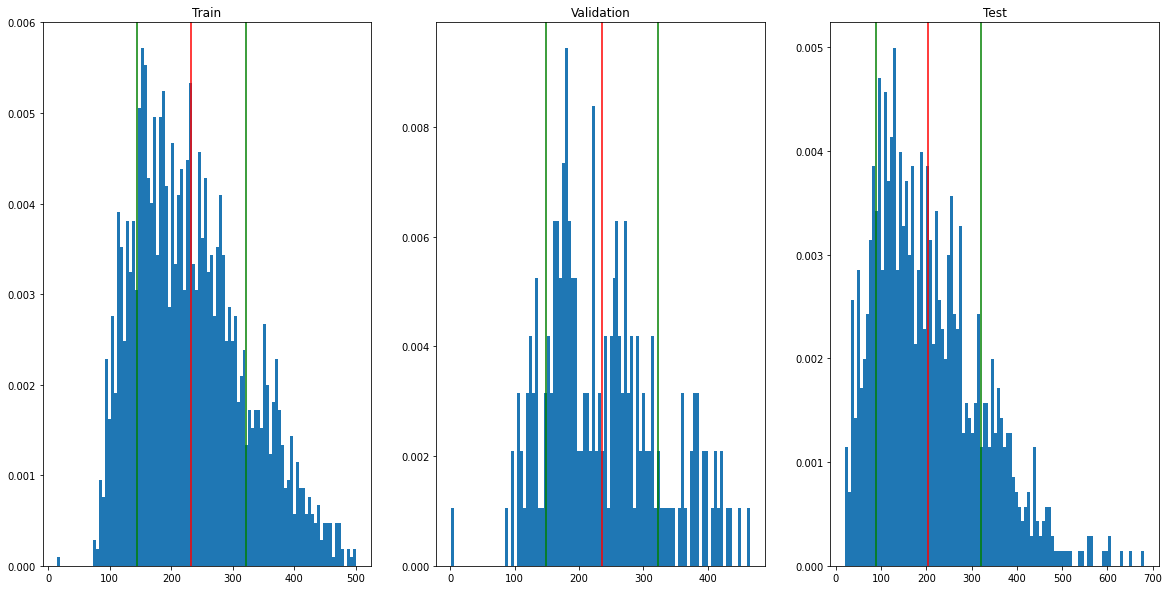

In [64]:
# plot the distribution and the mean and std for each set on the histogram
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
# normalize the histogram
plt.hist(shapes_train, bins=100, density=True)
plt.axvline(np.mean(shapes_train), color='red')
plt.axvline(np.mean(shapes_train) - np.std(shapes_train), color='green')
plt.axvline(np.mean(shapes_train) + np.std(shapes_train), color='green')
print("The shapes are arround : ", np.mean(shapes_train), " +- ", np.std(shapes_train))
plt.title("Train")
plt.subplot(1, 3, 2)
plt.hist(shapes_val, bins=100, density=True)
plt.axvline(np.mean(shapes_val), color='red')
plt.axvline(np.mean(shapes_val) - np.std(shapes_val), color='green')
plt.axvline(np.mean(shapes_val) + np.std(shapes_val), color='green')
print("The shapes are arround : ", np.mean(shapes_val), " +- ", np.std(shapes_val))
plt.title("Validation")
plt.subplot(1, 3, 3)
plt.hist(shapes_test, bins=100, density=True)
plt.axvline(np.mean(shapes_test), color='red')
plt.axvline(np.mean(shapes_test) - np.std(shapes_test), color='green')
plt.axvline(np.mean(shapes_test) + np.std(shapes_test), color='green')
print("The shapes are arround : ", np.mean(shapes_test), " +- ", np.std(shapes_test))
plt.title("Test")
plt.show()

In [79]:
def compute_mean_and_std(dataloader):
    mean = np.zeros(3)
    mean_square = np.zeros(3)
    nb_samples = 0.
    for data, _ in tqdm(dataloader):
        data = data.squeeze()
        # print(data.shape)
        # print(data.sum(axis=(1, 2)).shape)
        mean += np.array(data.sum(axis=(1, 2)))
        mean_square += np.array((data**2).sum(axis=(1, 2)))
        nb_samples += np.prod(data.shape[1:])

    mean_square /= nb_samples
    mean /= nb_samples
    std = np.sqrt(mean_square - (mean)**2)

    return mean, std

In [81]:
mean_train, std_train = compute_mean_and_std(train_loader)
mean_val, std_val = compute_mean_and_std(val_loader)
mean_test, std_test = compute_mean_and_std(test_set)


  0%|          | 0/1082 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/532 [00:00<?, ?it/s]

In [82]:
print("Mean train: ", mean_train)
print("Std train: ", std_train)
print("Mean val: ", mean_val)
print("Std val: ", std_val)
print("Mean test: ", mean_test)
print("Std test: ", std_test)

Mean train:  [0.44933458 0.45749243 0.3962494 ]
Std train:  [0.26013668 0.25813798 0.27011299]
Mean val:  [0.45317127 0.45367497 0.38284493]
Std val:  [0.26853051 0.26220681 0.26569007]
Mean test:  [0.44020012 0.44549118 0.37320143]
Std test:  [0.25109638 0.24793262 0.25689601]
